<a href="https://colab.research.google.com/github/andyharless/covid19states/blob/master/covid_positive_rate_etc_by_state.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import matplotlib.pyplot as plt

In [0]:
from google.colab import auth
auth.authenticate_user()
import gspread
from oauth2client.client import GoogleCredentials
gc = gspread.authorize(GoogleCredentials.get_application_default())

In [0]:
# Data from https://covidtracking.com
url = 'https://docs.google.com/spreadsheets/d/18oVRrHj3c183mHmq3m89_163yuYltLNlOmPerQ18E8w'

In [0]:
# Get data as a spreadsheet workbook
wb = gc.open_by_url(url)

In [0]:
# Get the sheet with daily data by state
data = wb.worksheet('States daily 4 pm ET').get_all_values()

In [6]:
# Convert to a Pandas DataFrame
full_df = pd.DataFrame(data)
full_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,Date,State,Positive,Negative,Pending,Hospitalized – Currently,Hospitalized – Cumulative,In ICU – Currently,In ICU – Cumulative,On Ventilator – Currently,On Ventilator – Cumulative,Recovered,Deaths
1,20200412,AK,272,"7,766",,,31,,,,,66,8
2,20200412,AL,"3,525","18,058",,,437,,189,,119,,93
3,20200412,AR,"1,280","18,442",,74,130,,43,30,39,367,27
4,20200412,AS,0,3,2,,,,,,,,


In [0]:
# Use the first row of data as column names
def set_first_row_as_header(df):
  new_header = df.iloc[0] # Grab the first row for the header
  df = df[1:]             # Take the data less the header row
  df.columns = new_header # Set the header row as the df header
  return(df)

In [0]:
# Convert data to the appropriate types
def convert_dtypes(df):
  for c in df.columns:
    if c=='Date':                   # 'Date' is a date
      df[c] = pd.to_datetime(df[c])  
    elif c=='State':                # 'State' is a string (default, so no action)
      pass                           
    else:                           # The rest are numeric, need to remove commas
      df[c] = pd.to_numeric(df[c].str.replace(',',''), errors='coerce')
  return(df)

In [0]:
# Proccess the data frames and calculate positive rates
full_df = set_first_row_as_header(full_df)
full_df = convert_dtypes(full_df)
full_df['Total'] = full_df.Positive+full_df.Negative.fillna(0)  # New definition
full_df['posrate'] = full_df.Positive / full_df.Total

In [10]:
# Find states with more than 1000 confirmed cases,
#   arranged in descending order of number of cases
current = full_df.sort_values(['Date', 'Positive'], ascending=False).head(50)
states = current[current.Positive>1000].State.values
states

array(['NY', 'NJ', 'MA', 'MI', 'PA', 'CA', 'IL', 'LA', 'FL', 'TX', 'GA',
       'CT', 'WA', 'MD', 'IN', 'CO', 'OH', 'TN', 'VA', 'NC', 'MO', 'AZ',
       'AL', 'WI', 'SC', 'NV', 'MS', 'RI', 'UT', 'OK', 'DC', 'KY', 'MN',
       'IA', 'OR', 'DE', 'ID', 'KS', 'AR', 'NM'], dtype=object)

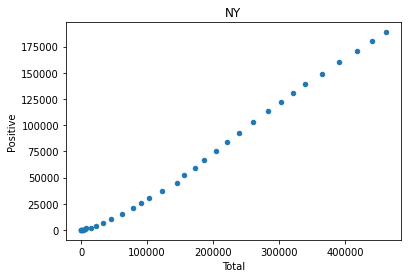

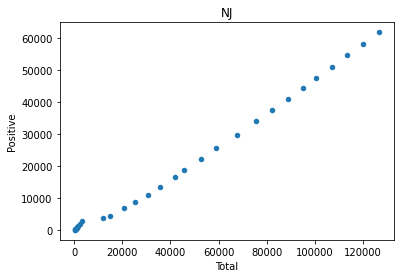

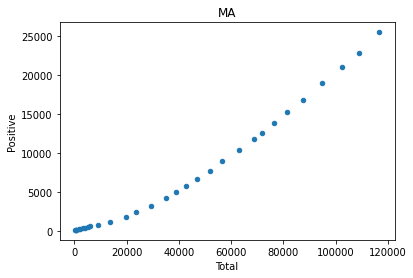

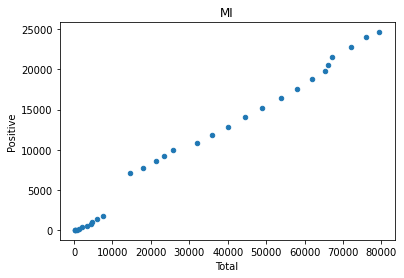

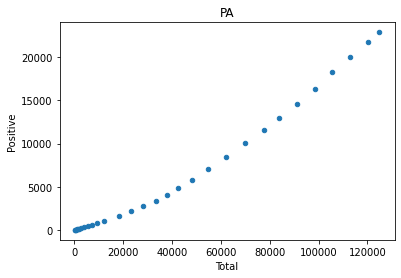

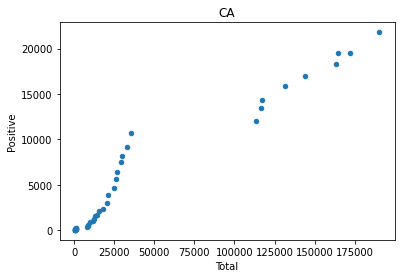

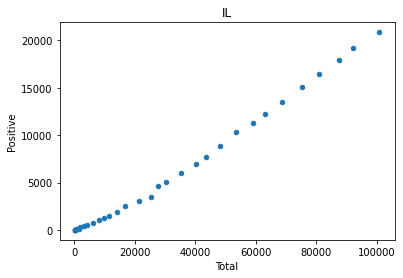

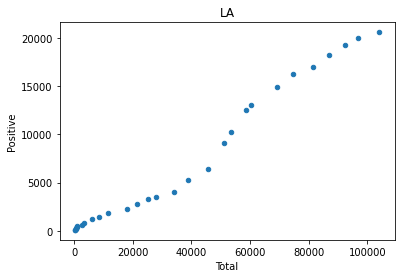

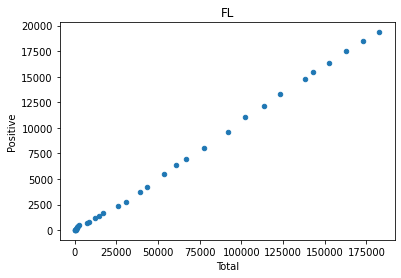

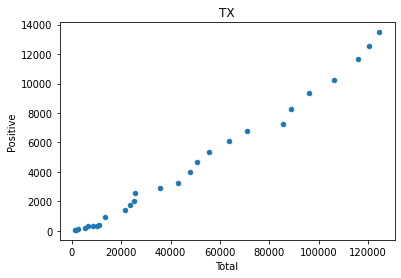

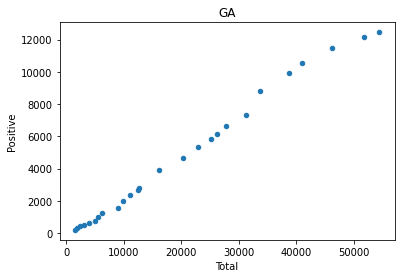

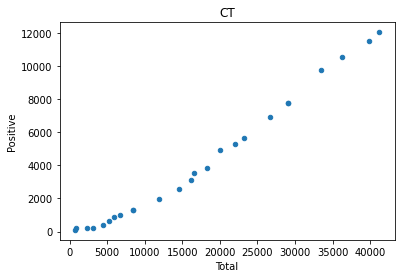

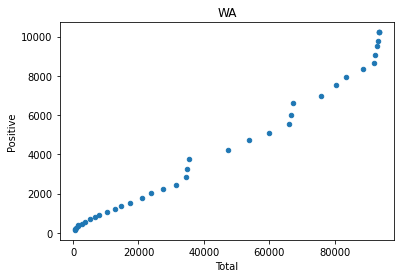

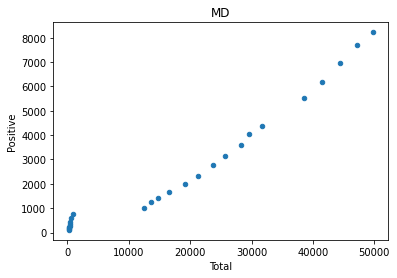

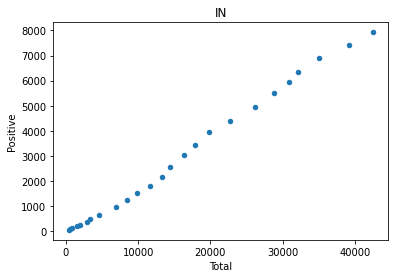

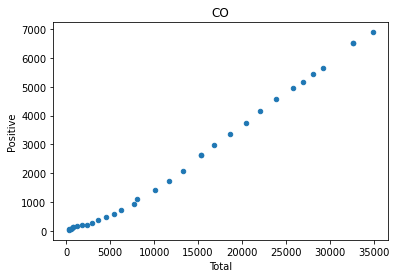

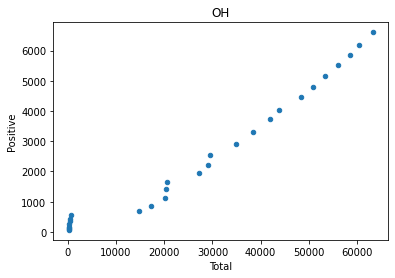

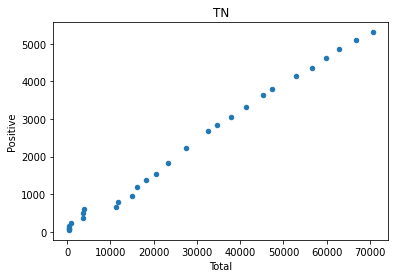

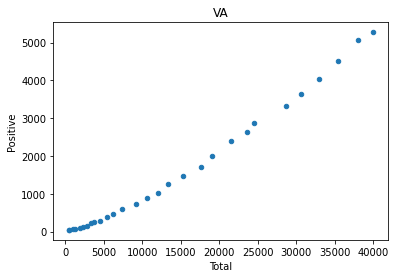

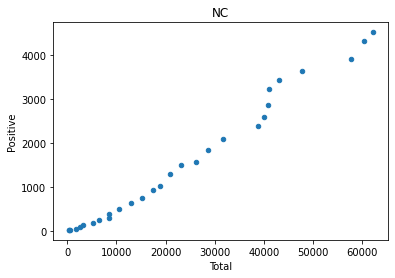

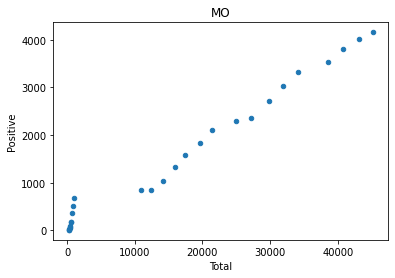

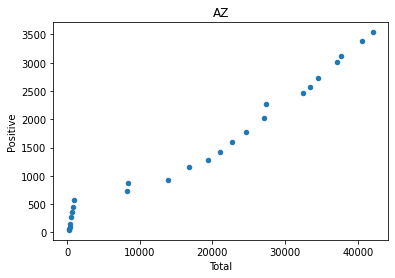

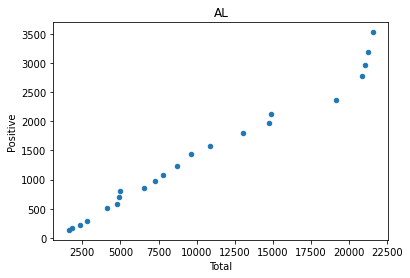

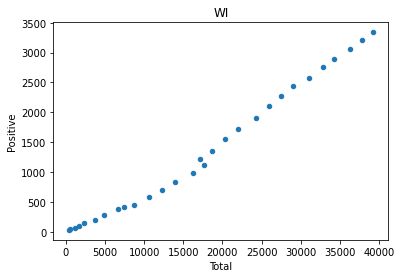

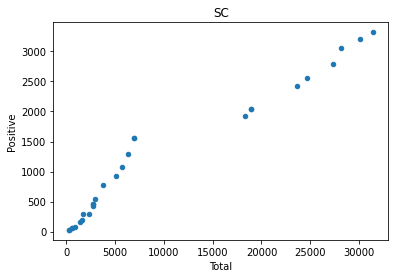

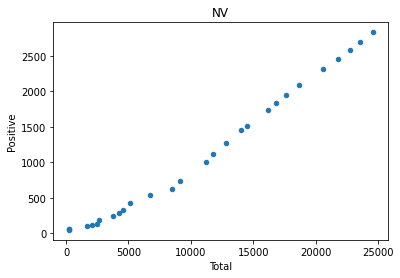

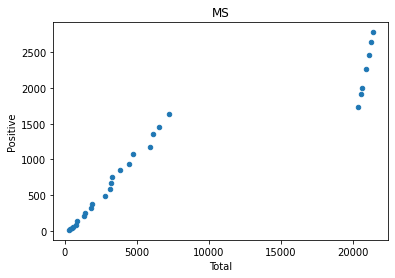

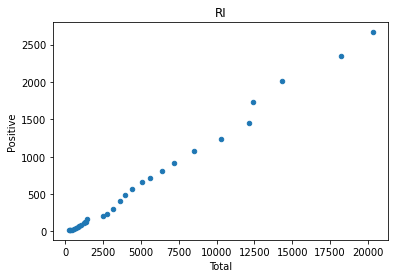

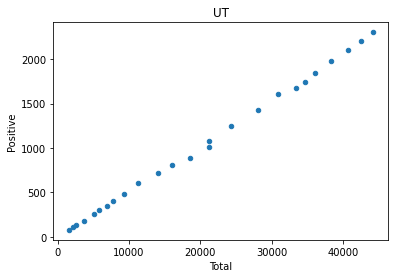

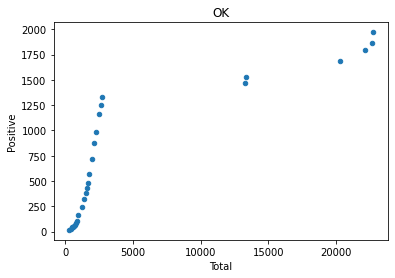

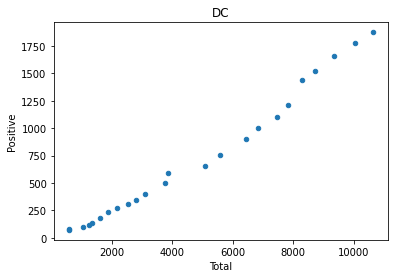

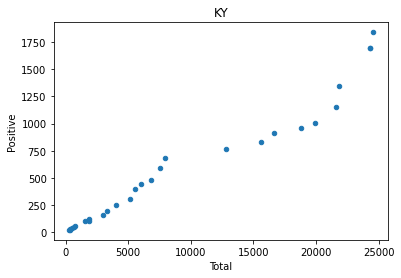

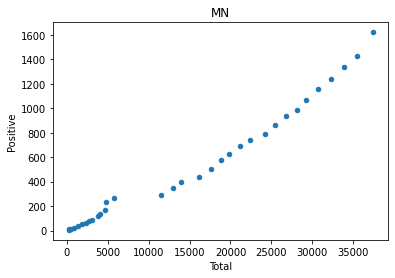

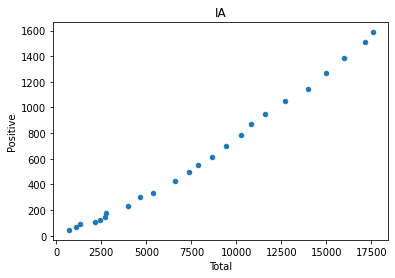

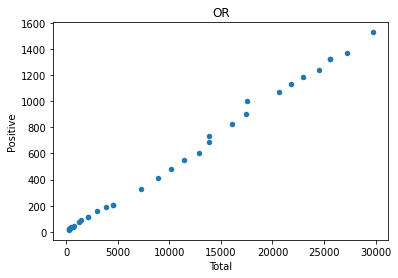

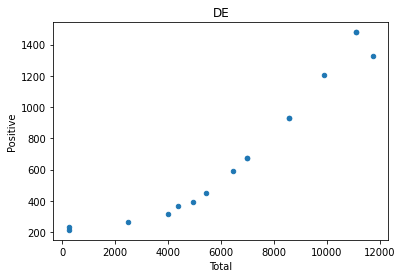

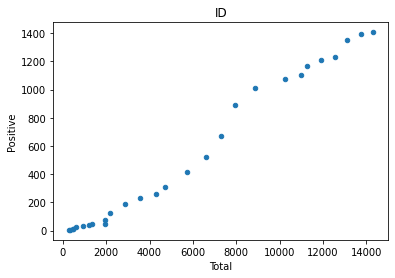

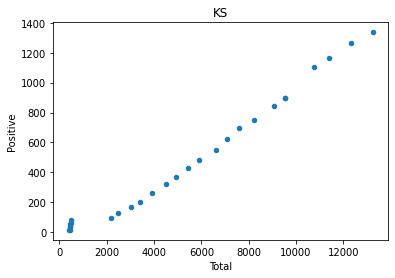

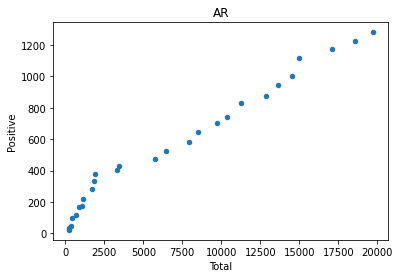

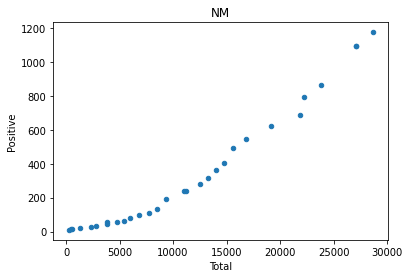

In [11]:
# Scatterplot  "Number of positive tests (confirmed cases)" 
#          vs. "Total number of cumulative tests"  (by state)

# We hope (but thus far do not find) that these plots will eventually start
#   to look like concave functions.  In other words, states should be testing
#   more and more people and hoping that, as testing is broadened, they find
#   a smaller proportion of infections among those tested.

for state in states:
  df = full_df[full_df.State==state]
  df[df.Total>200][['Total','Positive']].plot(kind='scatter', x='Total', y='Positive', title=state)
  plt.show()

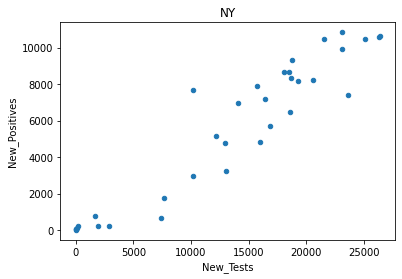

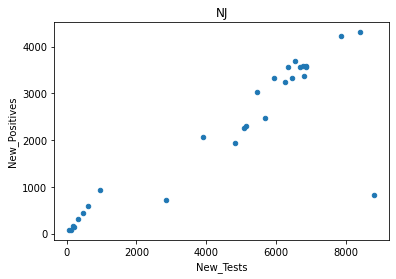

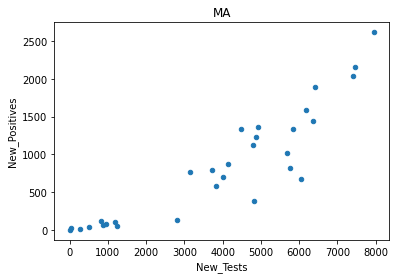

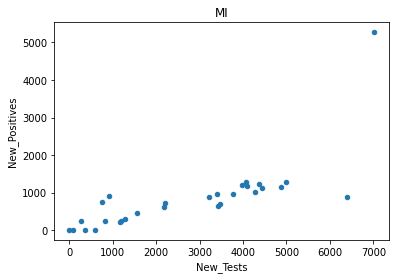

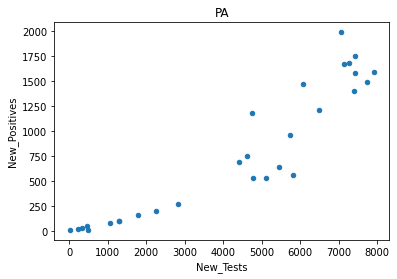

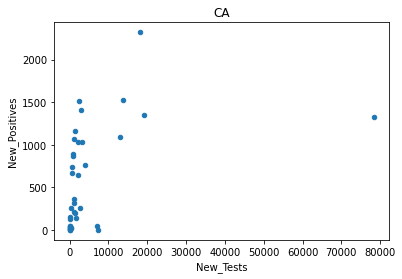

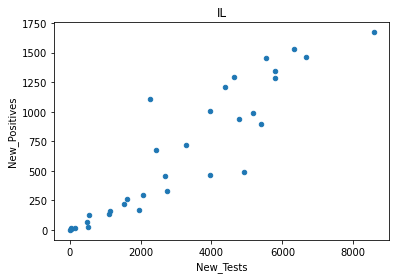

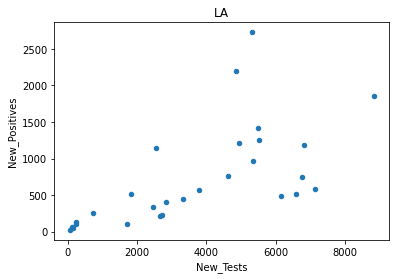

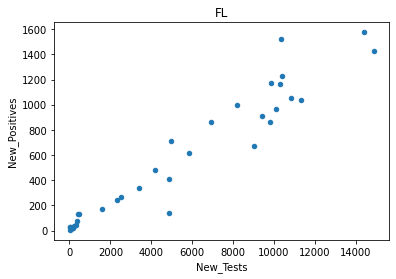

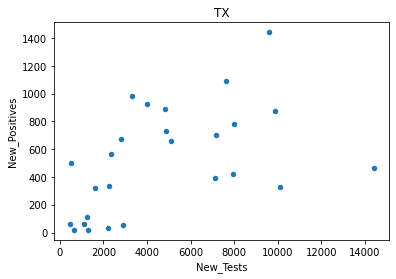

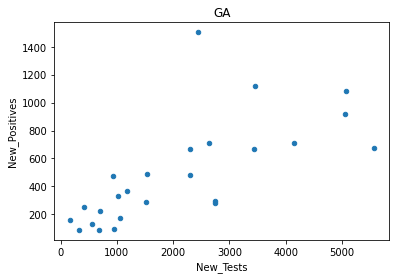

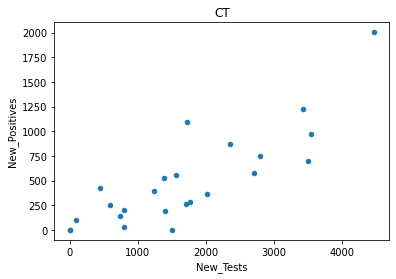

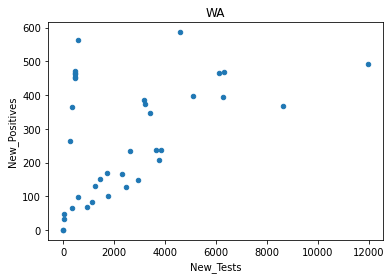

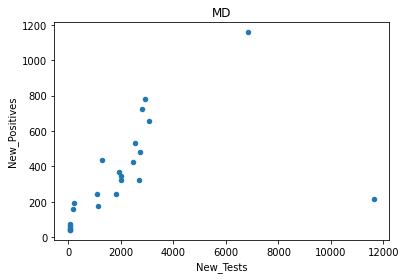

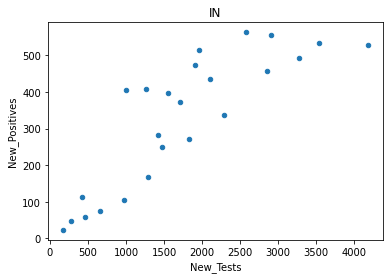

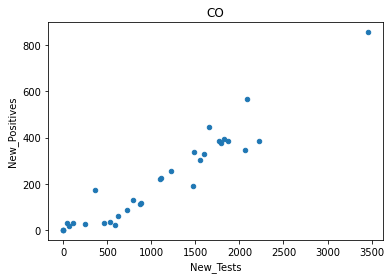

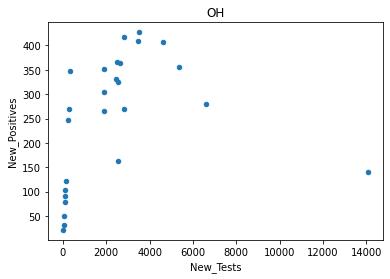

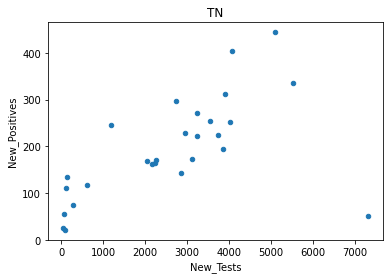

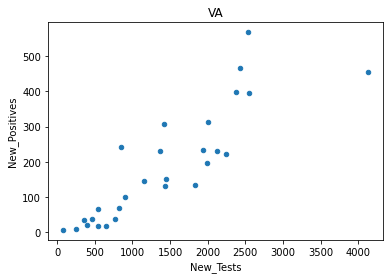

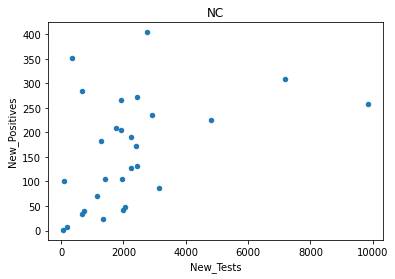

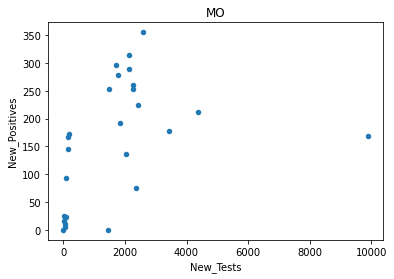

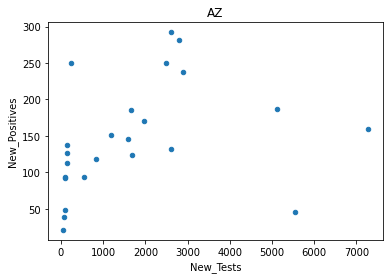

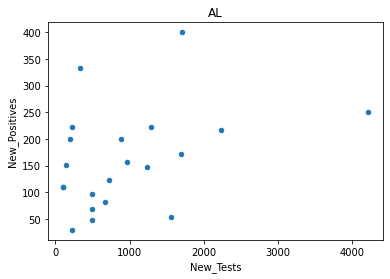

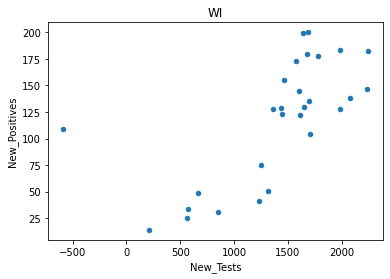

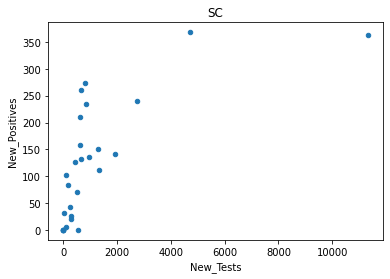

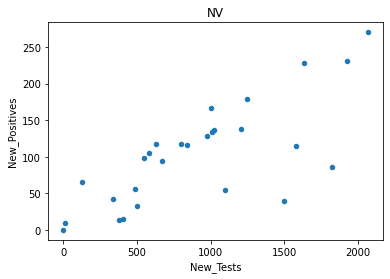

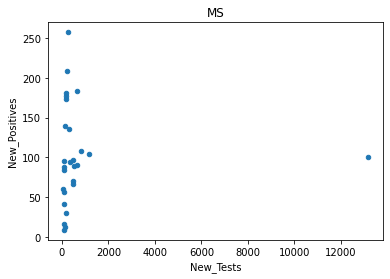

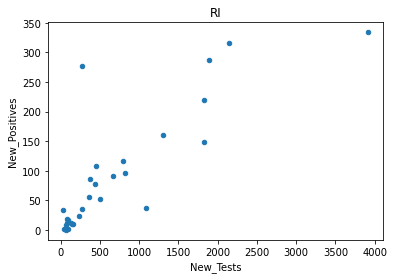

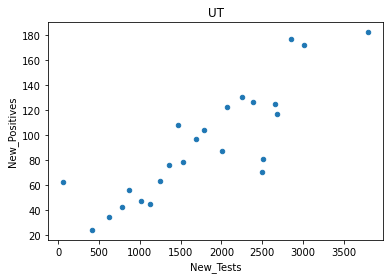

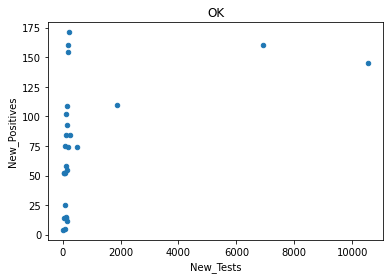

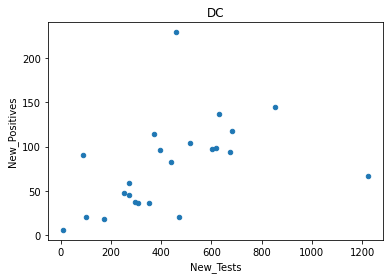

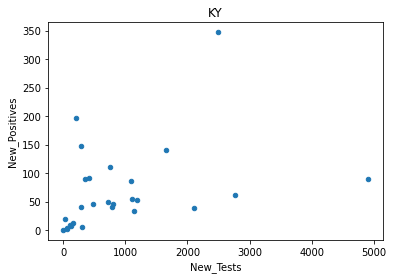

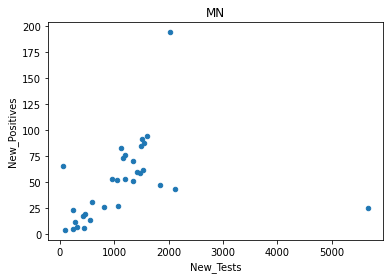

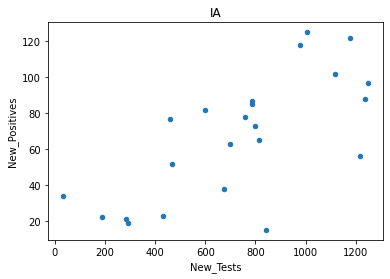

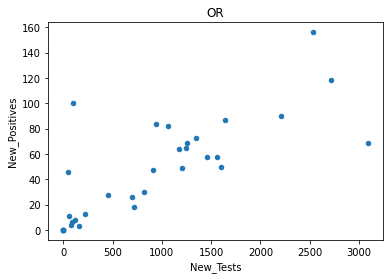

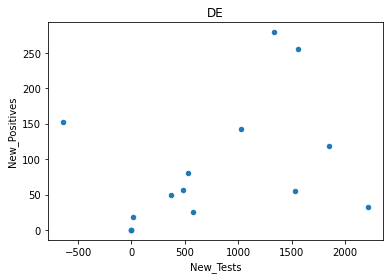

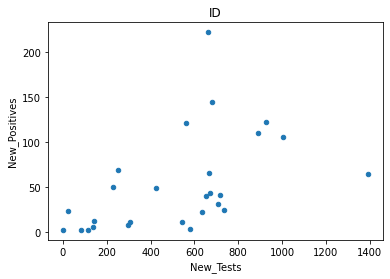

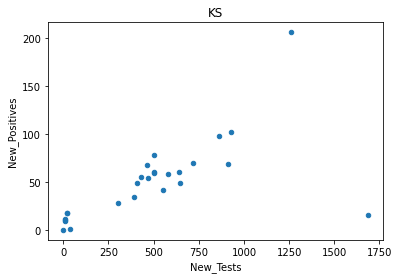

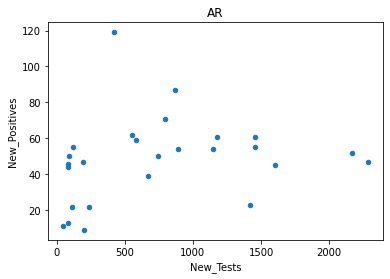

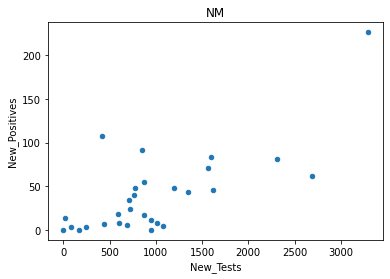

In [12]:
# Scatterplot  "Number of NEW positive tests (latest confirmed cases)" 
#          vs. "Total number of NEW tests"   (by state)

# We hope (but thus far do not find) that these will eventually flatten out.
#   Again, states should be testing more and more people and hoping that, 
#   as testing is broadened, they find a smaller proportion test positive.

for state in states:
  df = full_df[full_df.State==state].copy()
  df['New_Tests'] = -df['Total'].diff()
  df['New_Positives'] = -df['Positive'].diff()
  df[df.Total>200][['New_Tests','New_Positives']].plot(kind='scatter', 
                                                       x='New_Tests', 
                                                       y='New_Positives', 
                                                       title=state)
  plt.show()

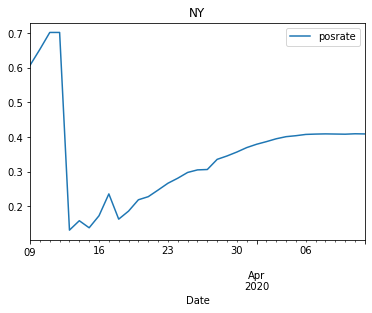

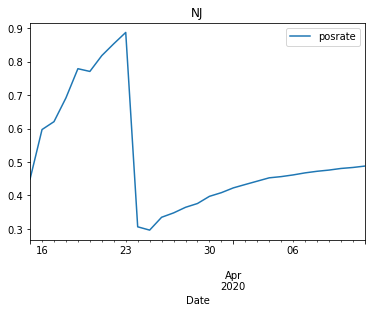

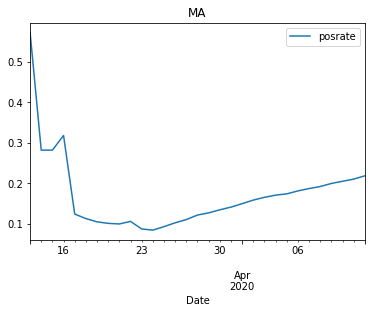

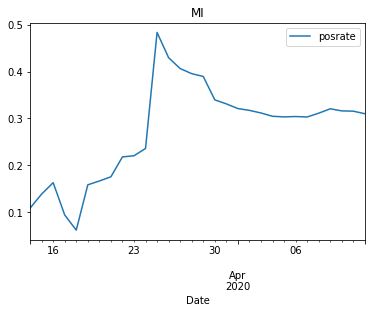

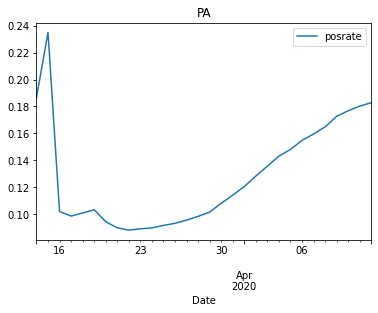

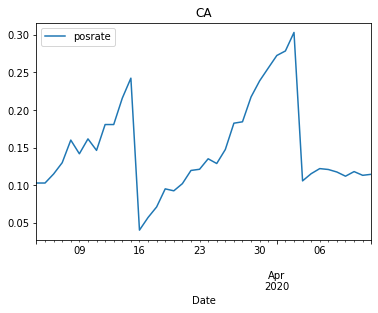

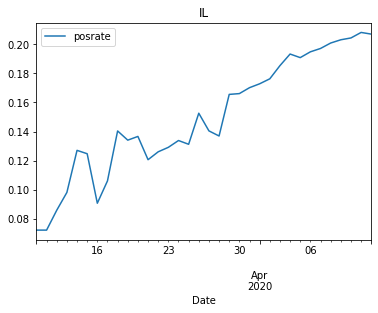

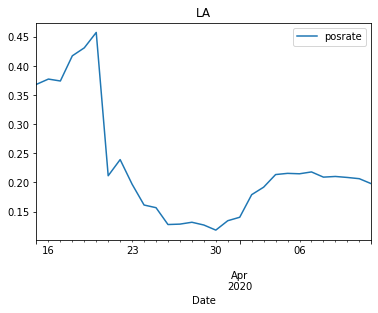

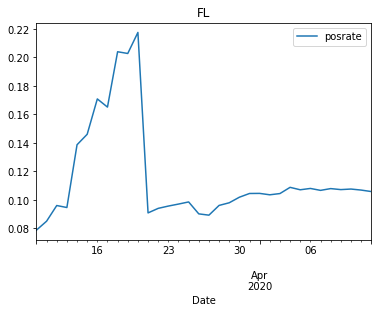

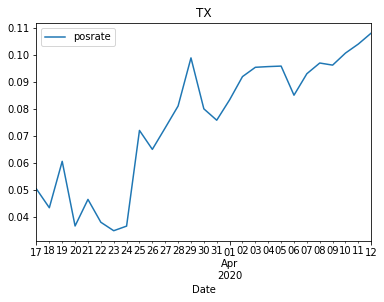

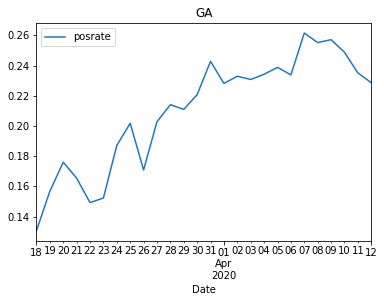

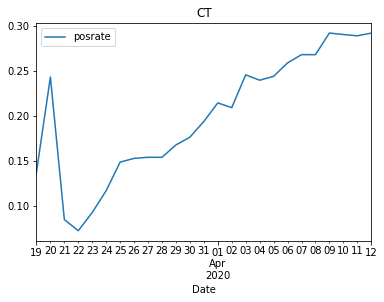

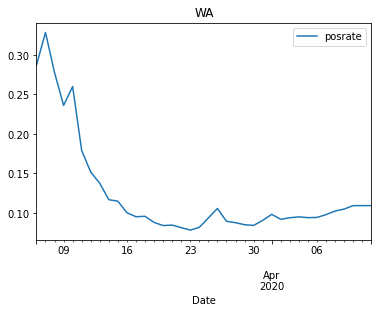

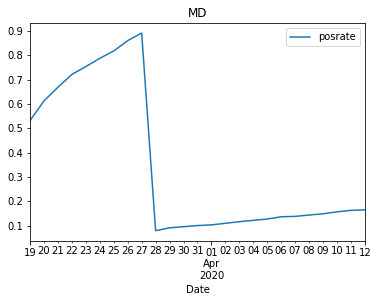

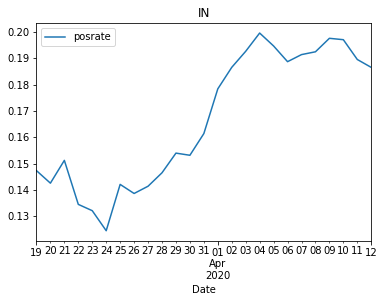

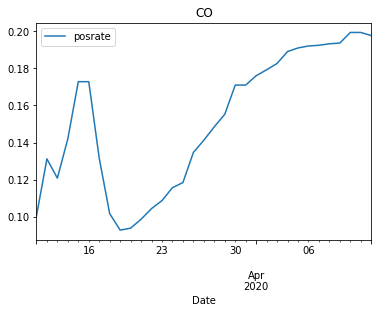

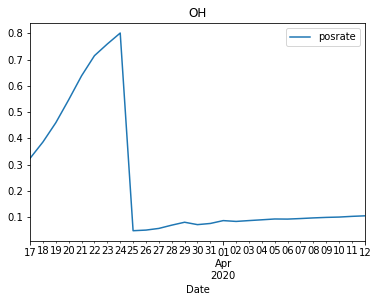

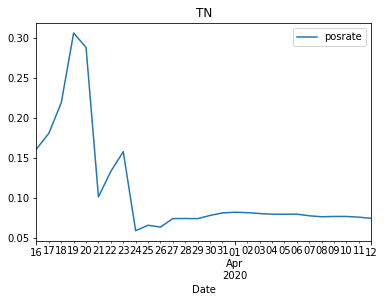

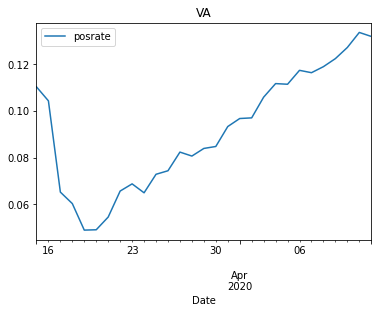

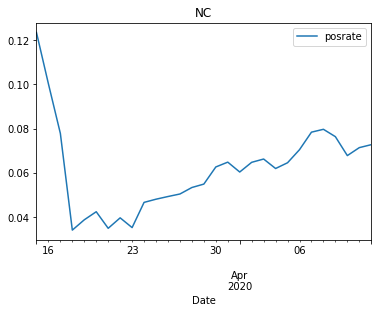

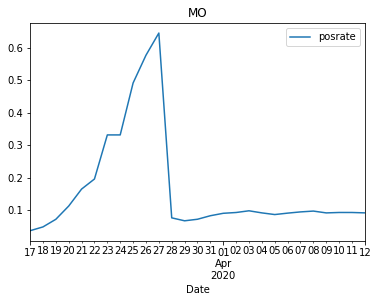

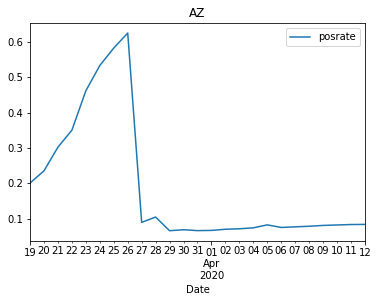

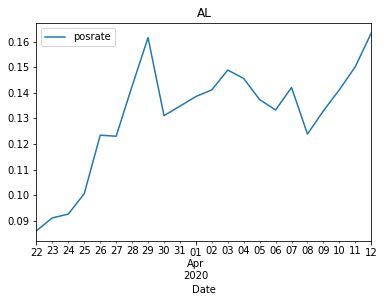

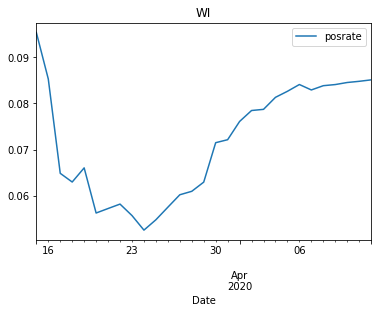

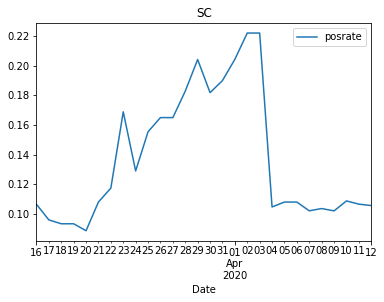

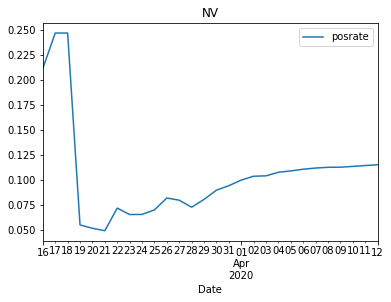

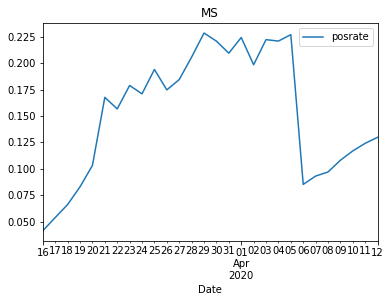

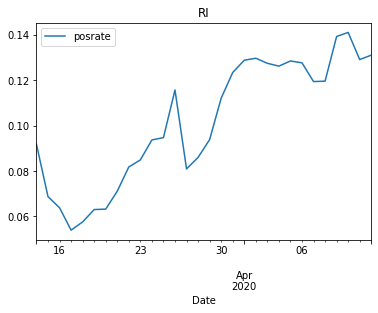

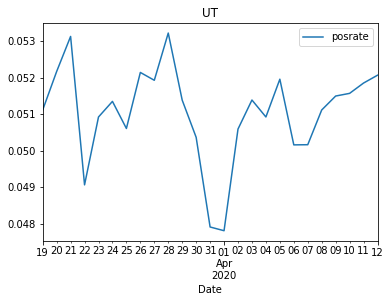

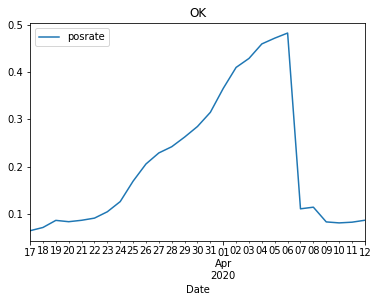

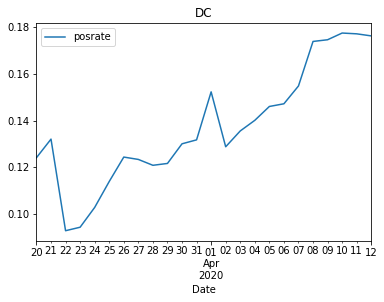

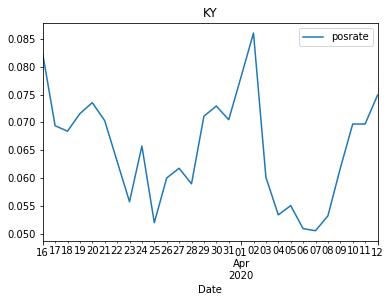

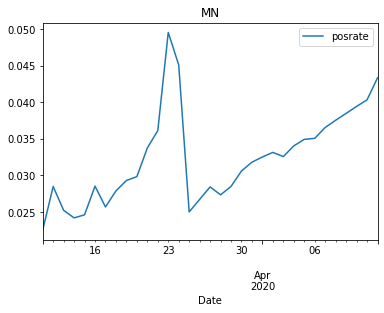

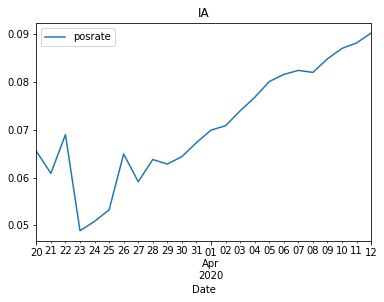

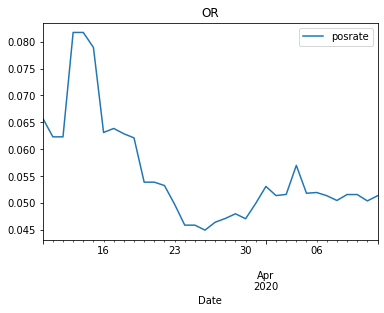

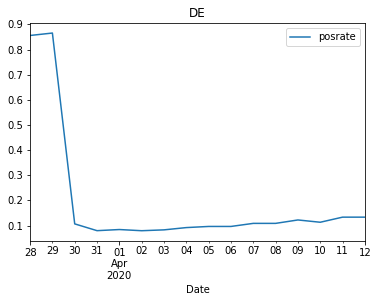

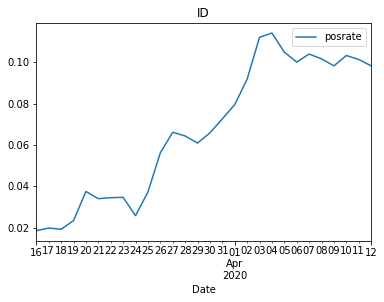

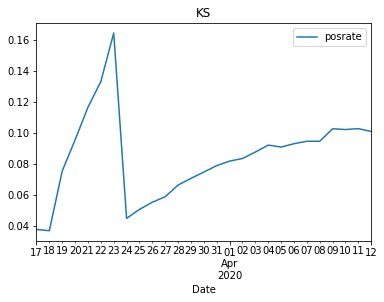

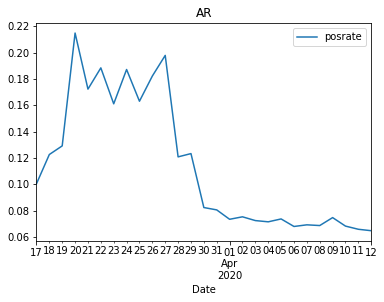

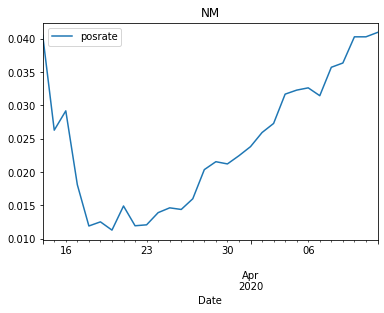

In [13]:
# Plot time series of fraction of tests that are positive (by state)
for state in states:
  df = full_df[full_df.State==state]
  df[df.Total>200][['Date','posrate']].set_index('Date').plot(y='posrate', title=state)
  plt.show()

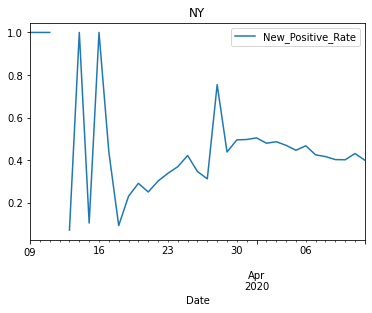

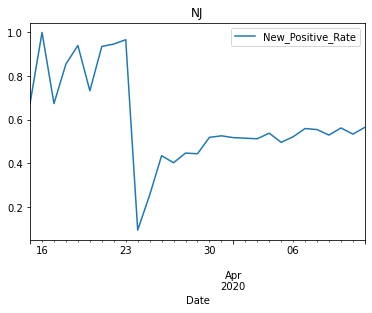

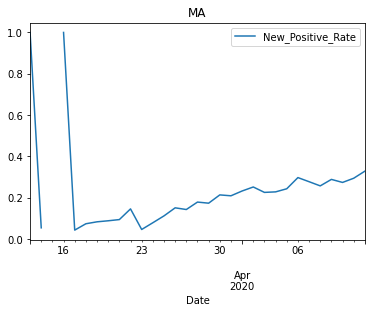

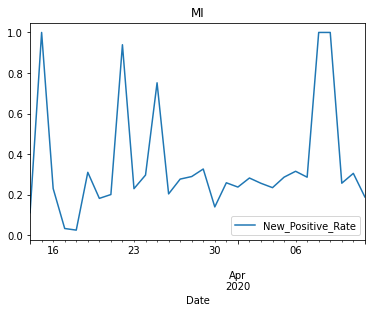

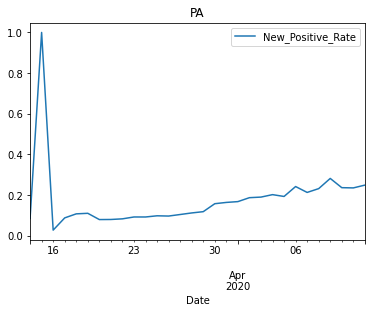

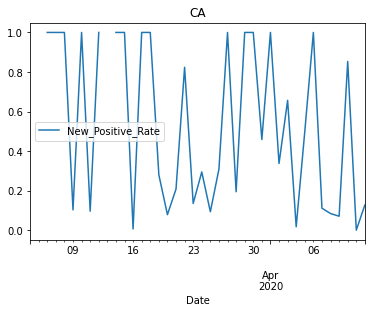

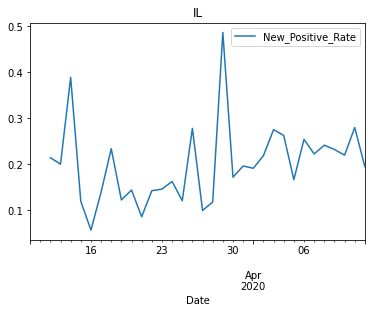

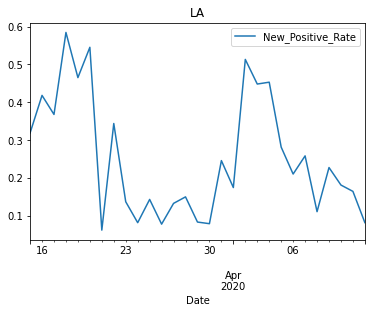

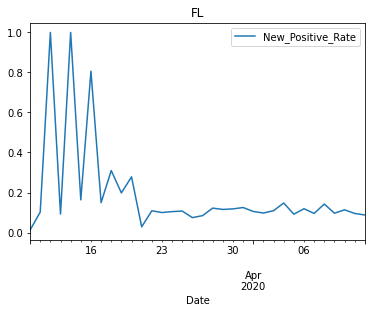

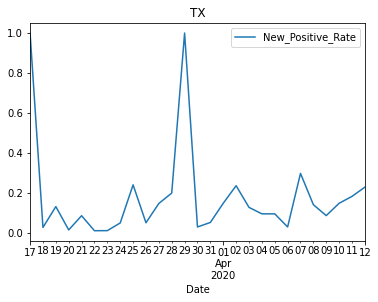

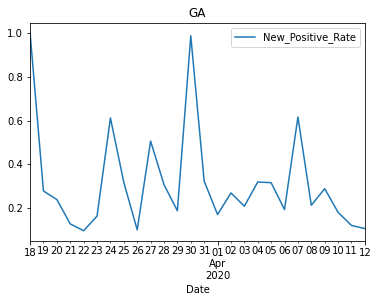

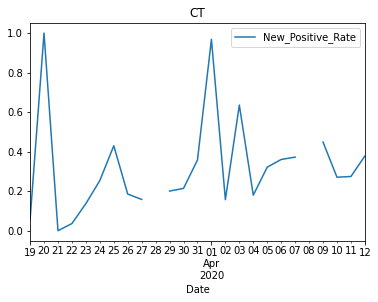

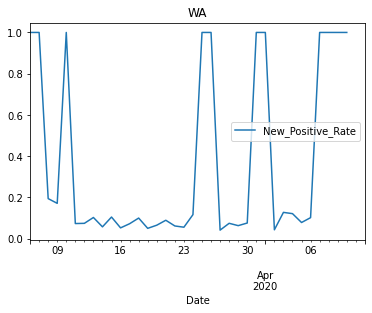

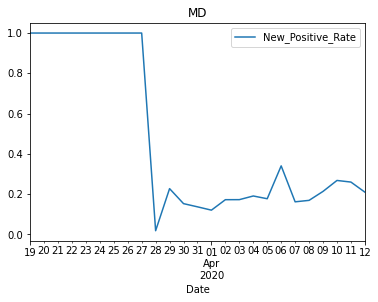

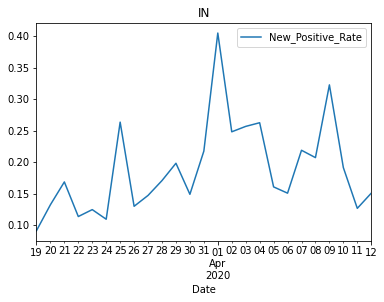

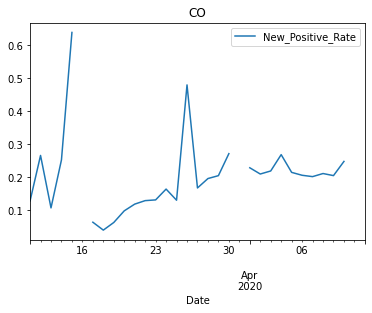

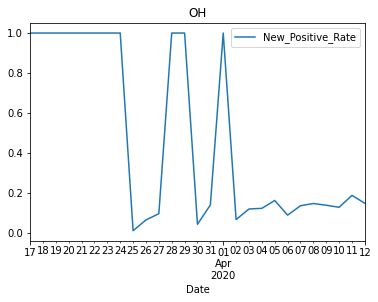

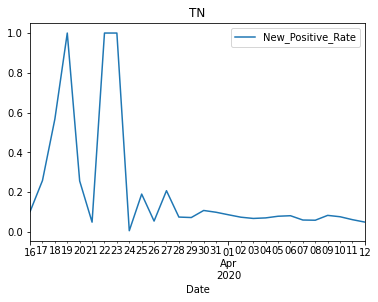

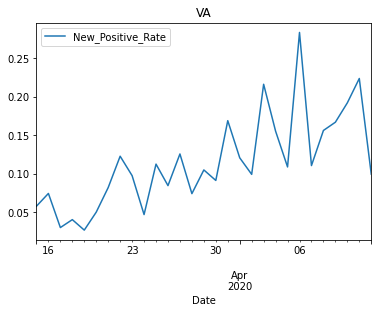

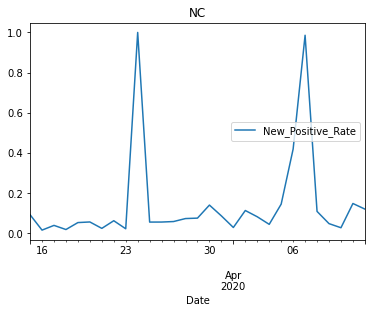

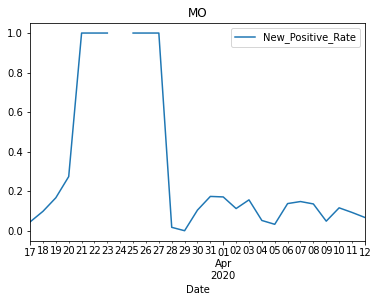

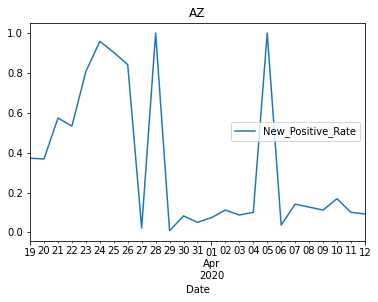

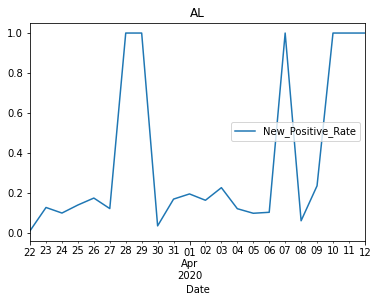

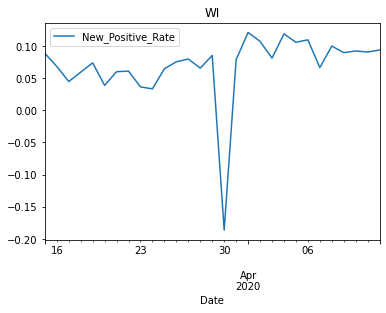

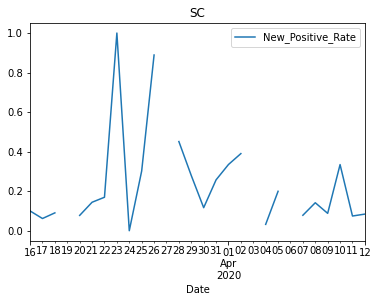

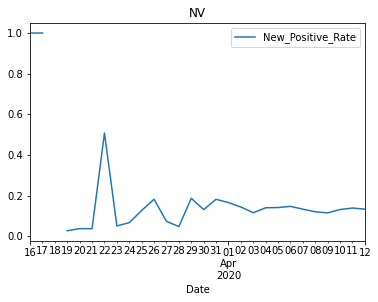

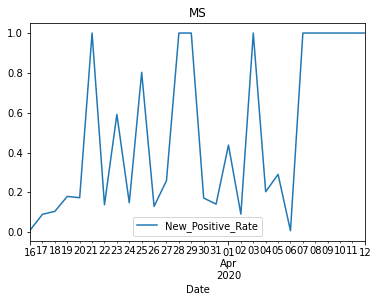

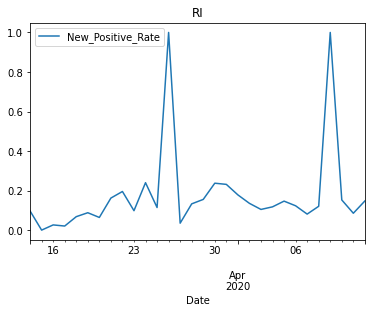

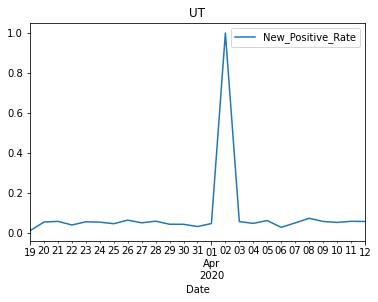

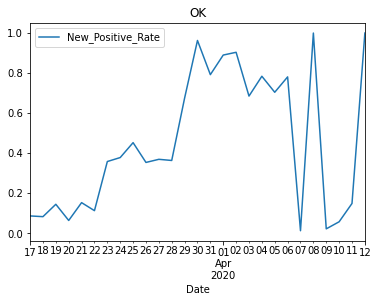

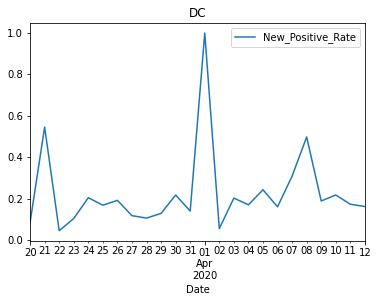

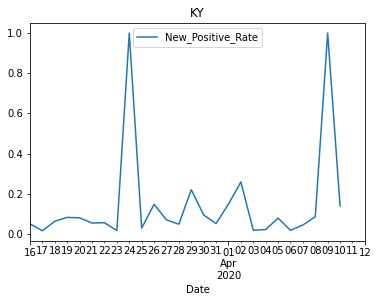

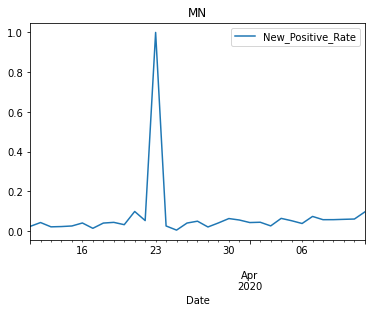

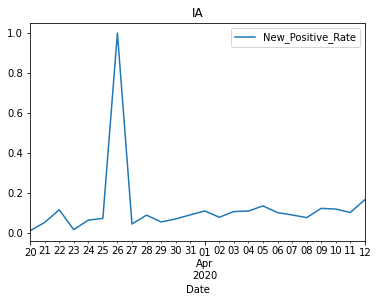

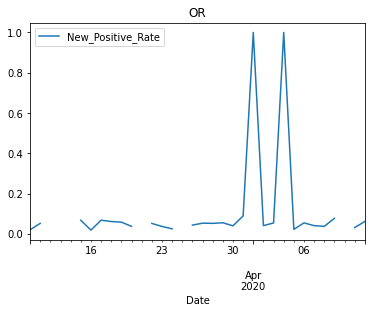

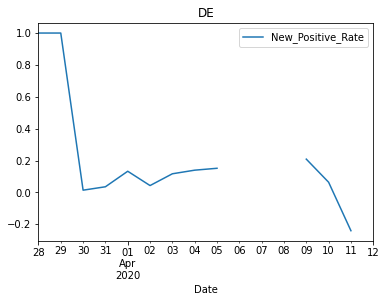

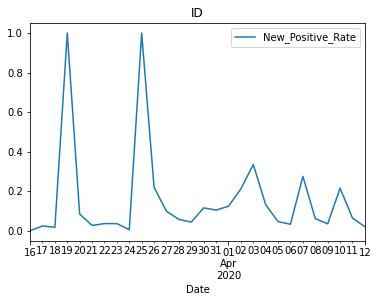

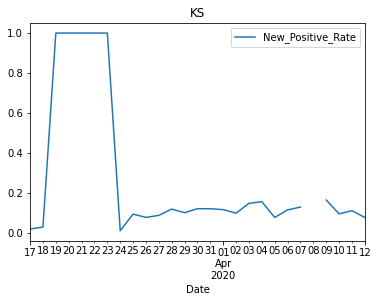

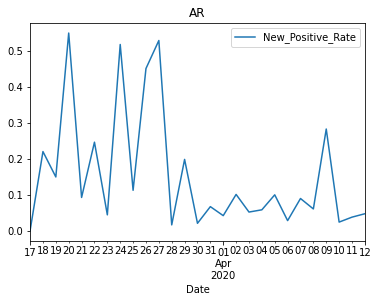

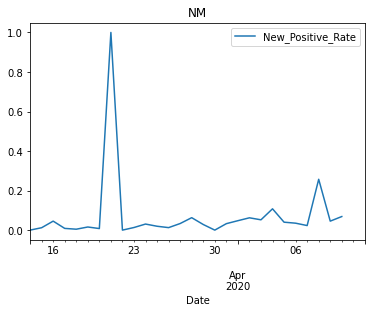

In [14]:
# Plot time series of fraction of NEW tests that are positive, by state
for state in states:
  df = full_df[full_df.State==state].copy()
  df['New_Positives'] = -df['Positive'].diff().shift(-1)
  df['New_Negatives'] = -df['Negative'].diff().shift(-1)
  df['New_Positive_Rate'] = df.New_Positives / (df.New_Positives+df.New_Negatives.fillna(0))
  df[df.Total>200][['Date',
                    'New_Positive_Rate']].set_index('Date').plot(y='New_Positive_Rate', 
                                                                 title=state)
  plt.show()

In [15]:
# Show mean fraction of cumulative positives (over time) by state, 
#   along with standard deviation
#   (These are sorted by increasing standard deviation, so the top of the table
#    represents states that have had the most consistent fraction of positive tests)
# It's noteworthy that most of the standard deviations are small compared to the means
#    and that the means vary quite a lot by state.
# So within-state results (for positive rate) are typically consistent over time
#    whereas positive rate varies a lot from one state to another
df = full_df[full_df.Date>'2020-03-16'][['Date', 'posrate', 'State']]
by_state = df[df.State.isin(states)].groupby('State')
by_state.posrate.agg(['mean', 'std']).sort_values('std')

,mean,std
State,,
OR,0.051766,0.004933
MN,0.033825,0.006111
WA,0.093496,0.008964
KY,0.064756,0.009232
NM,0.023535,0.009985
WI,0.070394,0.011754
NC,0.058053,0.014528
TX,0.075679,0.023947
IN,0.168758,0.025776


In [16]:
# Show mean fraction of DAILY positives (over time) by state, 
#   along with standard deviation
#   (These are sorted by increasing standard deviation, so the top of the table
#    represents states that have had the most consistent fraction of positive tests)
# These are less dramatic than the previous table, but still tend to show
#    that within-state results are typically consistent over time
#    whereas positive rate varies a lot from one state to another
df = full_df.sort_values(['State','Date']).copy()
df['New_Positives'] = df['Positive'].diff()  # Kluge because it's wrong when the state changes
df['New_Negatives'] = df['Negative'].diff()  #   but OK because we use only after 3/16
df['New_Positive_Rate'] = df.New_Positives / (df.New_Positives+df.New_Negatives.fillna(0))
df = df[df.Date>'2020-03-16'][['Date', 'New_Positive_Rate', 'State']]
by_state = df[df.State.isin(states)].groupby('State')
by_state.New_Positive_Rate.agg(['mean', 'std']).sort_values('std')

,mean,std
State,,
WI,0.068434,0.056387
FL,0.123151,0.057602
VA,0.117936,0.062076
PA,0.155691,0.064033
IN,0.195545,0.075224
IL,0.200113,0.081112
MA,0.186715,0.086246
CO,0.185322,0.087721
NY,0.403769,0.118992


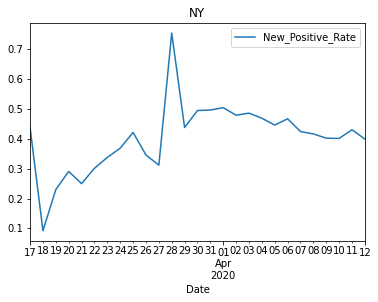

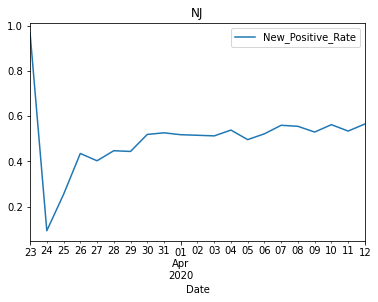

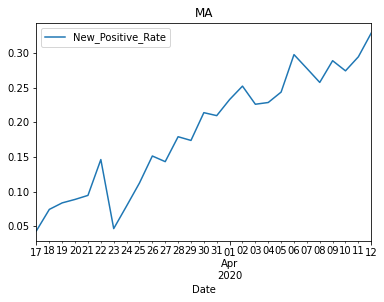

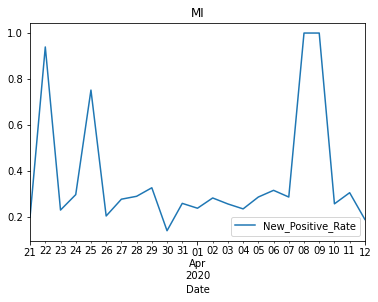

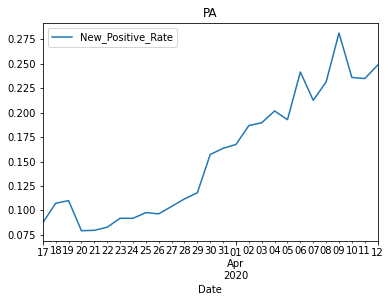

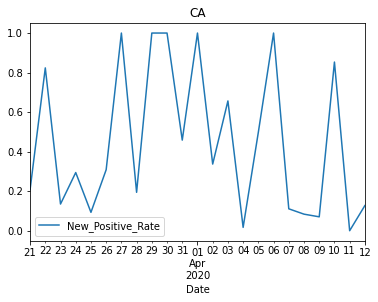

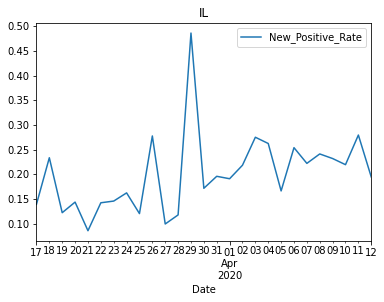

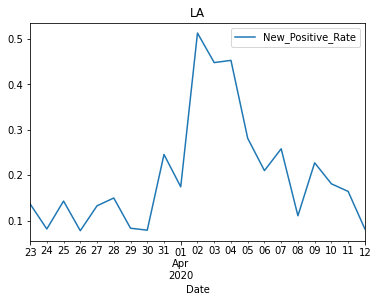

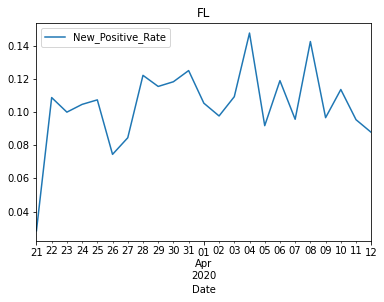

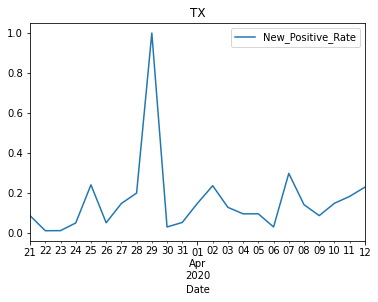

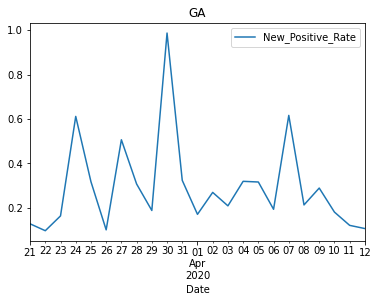

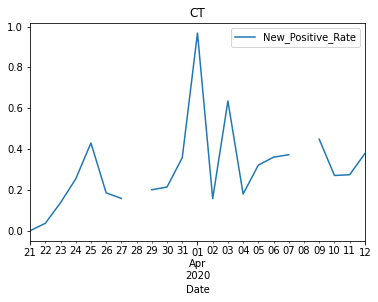

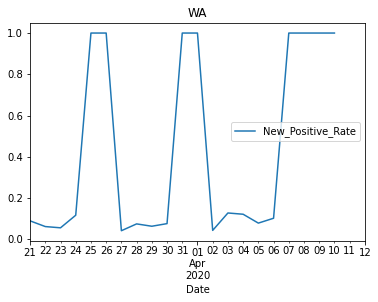

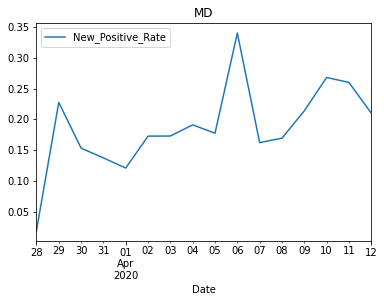

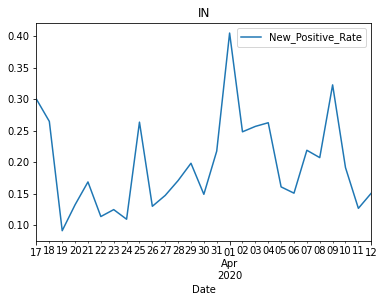

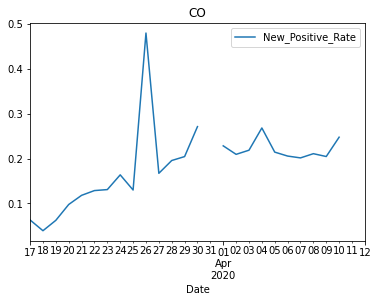

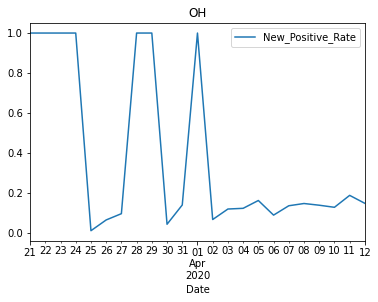

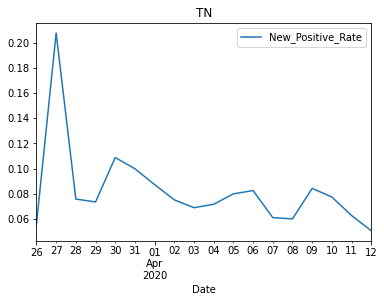

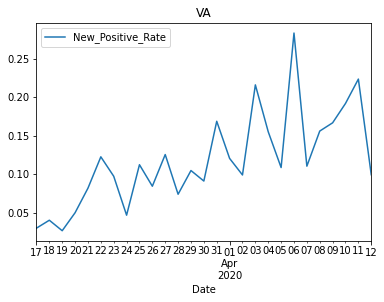

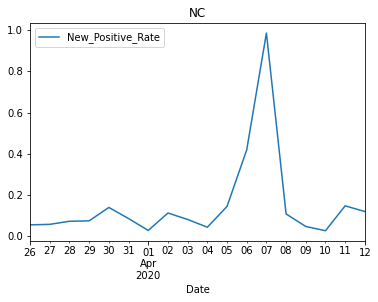

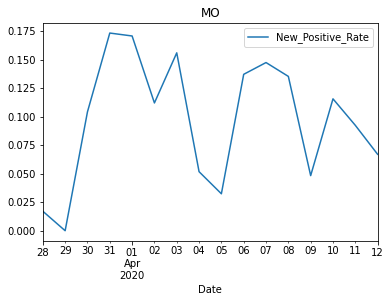

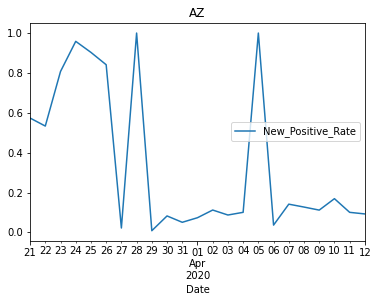

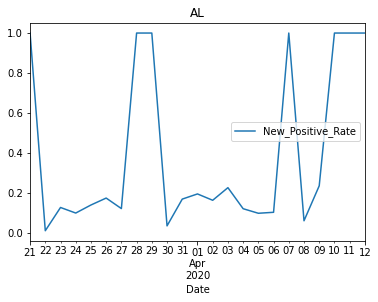

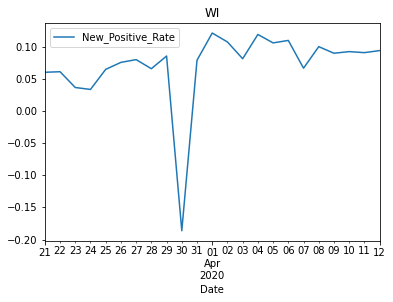

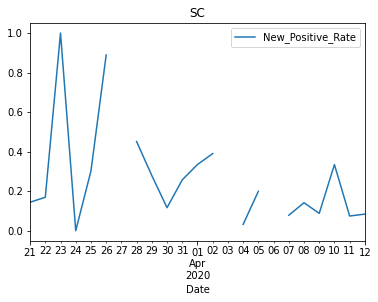

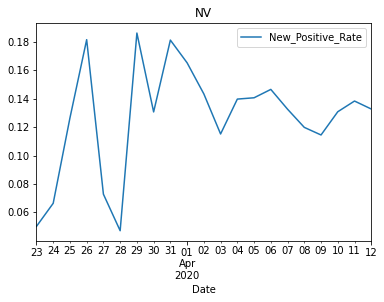

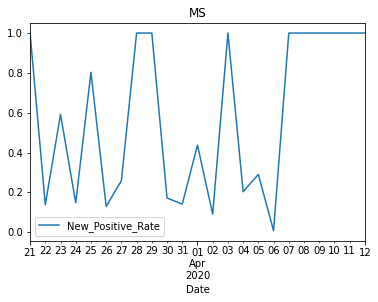

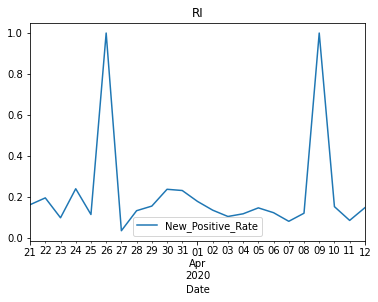

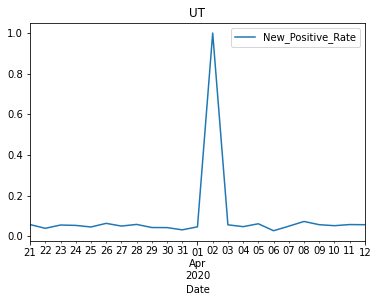

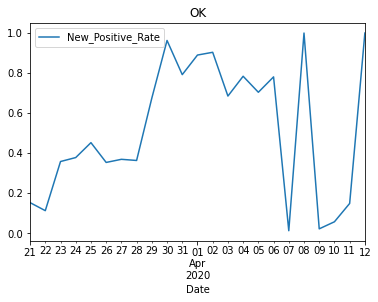

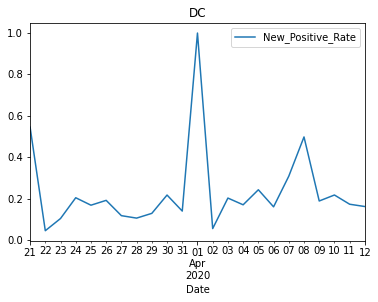

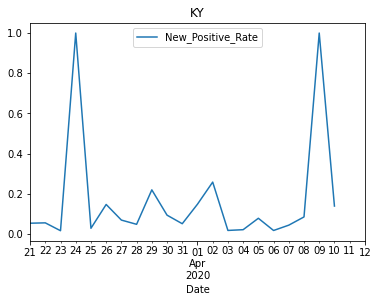

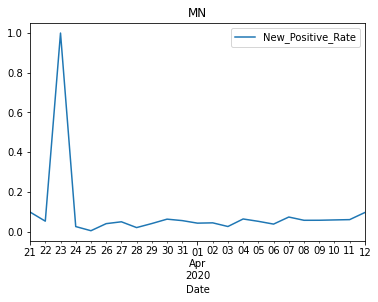

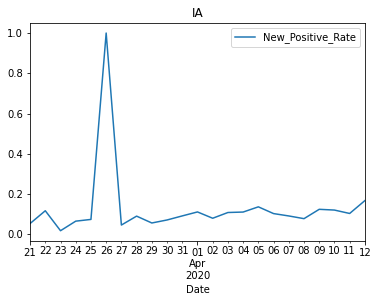

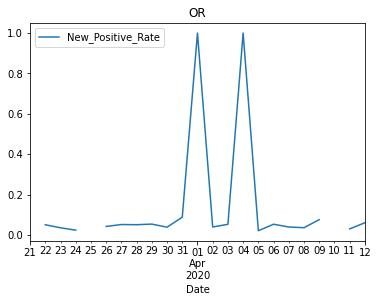

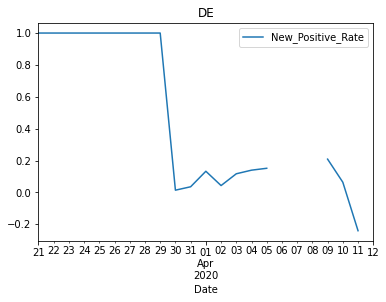

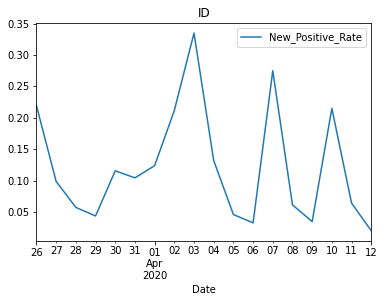

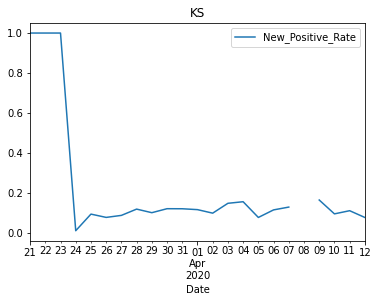

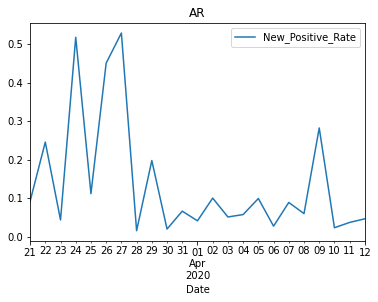

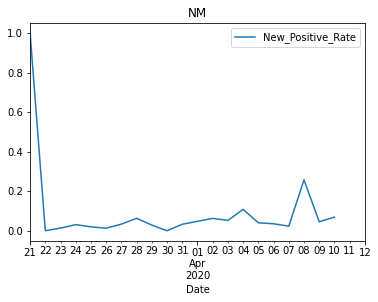

In [17]:
# Plot time series of fraction of NEW tests that are positive, by state,
#   with different start dates for different states, 
#   because positive rates stabilized at different times
for state in states:
  df = full_df[full_df.State==state].copy()
  df['New_Positives'] = -df['Positive'].diff().shift(-1)
  df['New_Negatives'] = -df['Negative'].diff().shift(-1)
  df['New_Positive_Rate'] = df.New_Positives / (df.New_Positives+df.New_Negatives.fillna(0))
  if state in ['NY', 'PA', 'MA', 'CO', 'IN', 'VA', 'IL', 'IN']:
    startdate = '2020-03-17'
  elif state in ['NJ', 'NV', 'LA']:
    startdate = '2020-03-23'
  elif state in ['ID', 'NC', 'TN']:
    startdate = '2020-03-26'
  elif state in ['MO', 'MD']:
    startdate = '2020-03-28'
  else:
    startdate = '2020-03-21'
  df[df.Date>=startdate][['Date',
                          'New_Positive_Rate']].set_index('Date'
                             ).plot(y='New_Positive_Rate', title=state)
  plt.show()